1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

Solution with minimize(x0=[0, 0]) is: ( 0.0 , 0.0 )
Solution with minimize(x0=[0, 0,75]) is: ( 0.08984201020477522 , -0.7126564216963296 )
basinhopping finds two global minima (0.08984201020477522 -0.7126564216963296) and (-0.08984201461662285 0.7126564044226885)


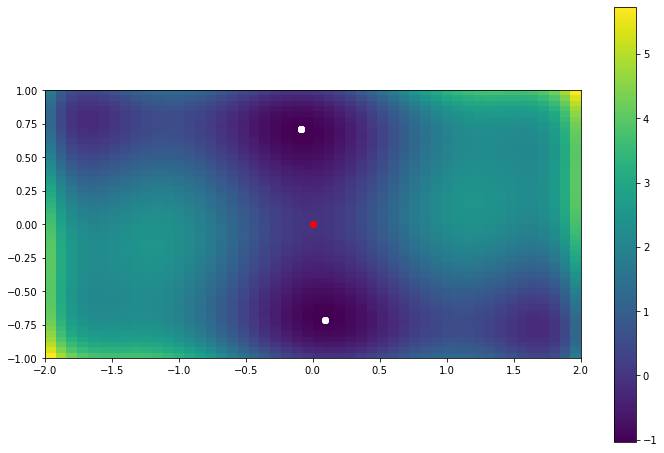

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import basinhopping
from scipy.optimize import shgo
from scipy import optimize

#Plot the function
def f(x):
    return (4-2.1*(x[0]**2)+((x[0]**4))/3)*x[0]**2 +x[0]*x[1] + (4*x[1]**2 -4)*x[1]**2

plt.figure(figsize=(12,8))
x = np.linspace(-2, 2)
y = np.linspace(-1, 1)
x1, y1 = np.meshgrid(x, y)
plt.imshow(f([x1, y1]), extent=[-2, 2, -1, 1], origin="lower")
plt.colorbar()


#Find minima and plot it
minima = optimize.minimize(f, x0=[0, 0])
plt.scatter(minima.x[0], minima.x[1], color='r')      # point (0,0) seems to be a local minima, but not a global one 
print("Solution with minimize(x0=[0, 0]) is: (", minima.x[0],",", minima.x[1],")")

minima = optimize.minimize(f, x0=[0, -0.75])
plt.scatter(minima.x[0], minima.x[1], color='r')      # point (0,-0.75) seems to be a true global minima
print("Solution with minimize(x0=[0, 0,75]) is: (", minima.x[0],",", minima.x[1],")")
#
for i in range(10):
    minima = basinhopping(f, x0=[0, 0])
    plt.scatter(minima.x[0], minima.x[1], color='w')
    #print("Solution with basinhopping(x0=[0, 0]) is:", minima.x[0], minima.x[1]) 
    
print("basinhopping finds two global minima (0.08984201020477522 -0.7126564216963296) and (-0.08984201461662285 0.7126564044226885)")


# Another function which finds the same global minima of basinhopping
# bounds = [(-2, 2), (-1, 1)]
# minima = shgo(f, bounds, n=128, sampling_method='sobol')
# plt.scatter(minima.x[0], minima.x[1], color='w')

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

[ 27.94963542 -10.58169952  -0.41848762   2.07379421]
[-36.71257853 -25.14962102  -0.90850645   2.10546884]


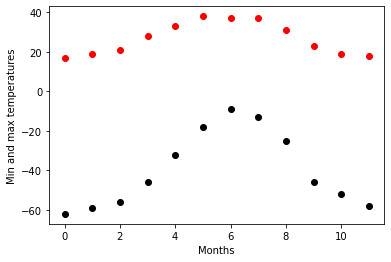

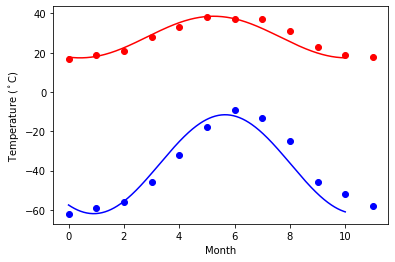

In [19]:
#Plot the temperatures
maxt = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
mint = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

months = np.arange(12)
fig, ax = plt.subplots()
ax.scatter(months, maxt, c='r')
ax.scatter(months, mint, c='k')
plt.xlabel('Months')
plt.ylabel('Min and max temperatures')

#Fitting
def yearly_temps(times, avg, ampl, time_offset, freq):
    return (avg + ampl * np.cos((times + time_offset) * freq * np.pi / times.max()))

res_max, _ = optimize.curve_fit(yearly_temps, months, maxt, [6, 10, 0, 2.5])
res_min, _ = optimize.curve_fit(yearly_temps, months, mint, [5, 20, 0, 1.5])
print(res_max)
print(res_min)
days = np.linspace(0, 10, num=365)

plt.figure()
plt.plot(months, maxt, 'ro')
plt.plot(days, yearly_temps(days, *res_max), 'r-')
plt.plot(months, mint, 'bo')
plt.plot(days, yearly_temps(days, *res_min), 'b-')
plt.xlabel('Month')
plt.ylabel('Temperature ($^\circ$C)')
plt.show()


#The plot fit look reasonable with cosine func and the time offset for min and max temperatures is the same within the fit accuracy

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

Max and min values in 'residuals' before cleaning are:  11.32000000000005 -160.8499999999989
Max and min values in 'residuals' after cleaning are:  2.9999999999995453 -2.9899999999998954
n degrees of freedom = 49
chi2 = 4497274.725843313
p-value = 0.0


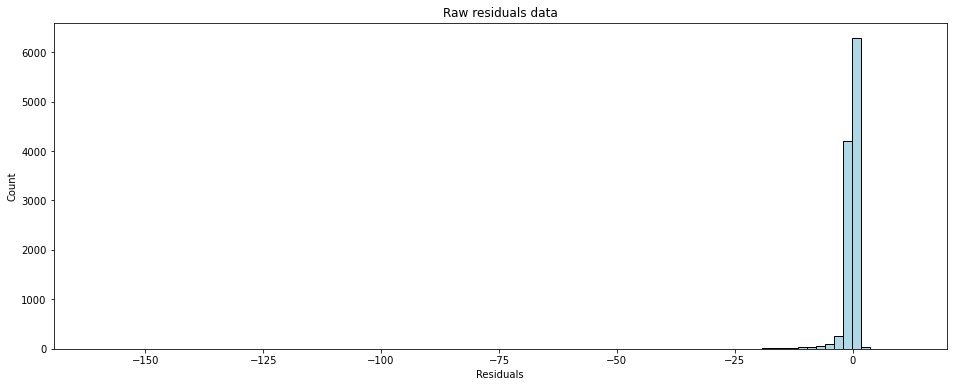

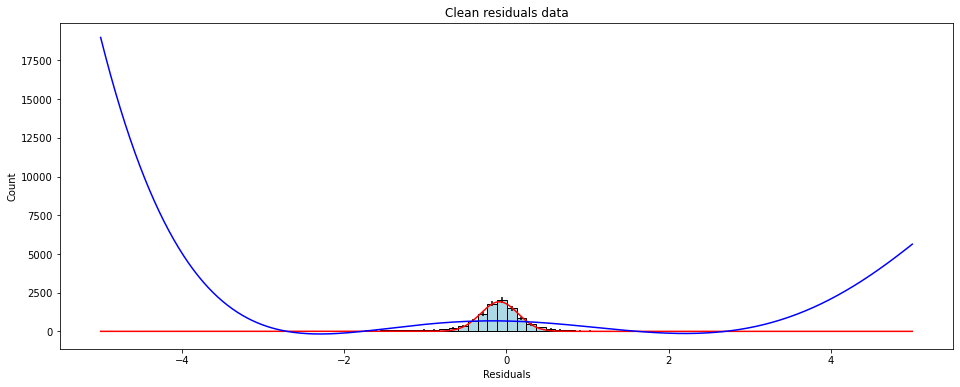

In [34]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from scipy import optimize, stats
import math

file = open('./data/residuals_261.pkl', 'rb')
data = pickle.load(file).item()
res = list(data['residuals'])

print("Max and min values in 'residuals' before cleaning are: ", max(res), min(res))
fig, ax = plt.subplots(figsize=(16, 6))
h, bins, _ = plt.hist(res, bins=90, density=False, facecolor='lightblue', edgecolor = "k",cumulative=False)
ax.set_title('Raw residuals data')
ax.set_xlabel('Residuals')
ax.set_ylabel('Count')

#Cleaning the data
res = [x for x in res if x>(-3) and x<3]
print("Max and min values in 'residuals' after cleaning are: ", max(res), min(res))
fig2, ax2 = plt.subplots(figsize=(16, 6))
h, bins, _ = plt.hist(res, bins=50, density=False, facecolor='lightblue', edgecolor = "k",cumulative=False)
ax2.set_title('Clean residuals data')
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Count')
bin_ranges = list(zip(bins,bins[1:]))

#Poisson uncertainty
centers = [(x[0]+x[1])/2 for x in bin_ranges]
sigma_poisson = list(np.sqrt(h))
#ax2.errorbar(centers, h, yerr=sigma_poisson, fmt='.k')   error bars are not clear with plt.errorbar, should rescale the res values
lines = [[(x[0], x[1]-4*x[2]), (x[0], x[1]+4*x[2])] for x in zip(centers, h, sigma_poisson)]
lc = mc.LineCollection(lines, colors='k', linewidths=1.5)
ax2.add_collection(lc)

#Fitting a gaussian     --------- not a good fit
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
popt, pcov = optimize.curve_fit(gauss_function, centers, h, p0 = [1, 0, 1])
x = np.linspace(-5, 5, num=500)
ax2.plot(x, gauss_function(x, popt[0], popt[1], popt[2]), label='gaussian', color='r')

#Fitting 5th order polynomial   --------- not a good fit

def f5(x, a0, a1, a2, a3, a4, a5):
    return a0 + a1 * x + a2 * x**2 + a3 * x**3 + a4 * x**4 + a5 * x**5
popt, pcov = optimize.curve_fit(f5, centers, h, p0 = [2, 2, 2, 2, 100, 100])
x = np.linspace(-5, 5, num=500)
ax2.plot(x, f5(x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]), label='polynomial f5', color='blue')


#Fitting a poisson distribution     -------- can't make it work

# def poisson(x, mean, amplitude):
#     fact = 1  
#     for i in range(1,x+1):
#         fact = fact * i
#     exp = np.exp(-(mean))
#     print(fact, exp)
#     return amplitude * ((mean**x * exp)/ fact)
# popt, pcov = optimize.curve_fit(poisson, centers, h, p0 = [1, 1])
# x = np.linspace(-5, 5, num=500)
# ax2.plot(x, poisson(x, popt[0], popt[1]), label='polynomial f5', color='blue')
# ax2.legend(loc=(0.8, 0.8))


#Goodness-of-fit test
ndof = len(centers) - 1
print("n degrees of freedom =", ndof)
chi2 = np.sum(((h - gauss_function(centers, popt[0], popt[1], popt[2]))**2) / sigma_poisson)
print("chi2 =", chi2)
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue) 

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

The best parameters are: 
Amplitude(a)= -9.962034680727287 
Phase(b)= 6.0485575505393 
Offset(c)= 9.262821312481801
The value of b just bring a phase offset to fit the real model of season cycles.

The overall average temperature is 9.261252084167237
Max and min temperatures during the year predicted by the model = 19.224078348996002 -0.6973698867454612


############### Fit with model g ############# 

The best parameters are: 
Amplitude(a)= -9.960785414394735 
Frequency(b)= 1.0002931706814773 
Phase(c)= 2.3459392458898636 
Offset(d)= 9.265671755930661
Test f vs g:
CL: 0.880 , additional parameter necessary: NO


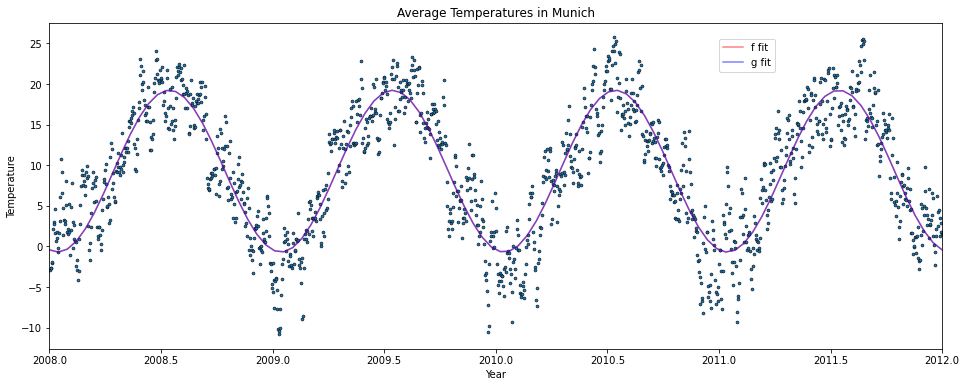

In [48]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


x, y = np.loadtxt(open('data/munich_temperatures_average_with_bad_data.txt'), unpack = True)
def func(x, a, b, c):
    return a*np.cos((2*np.pi*x)+b)+c

xt = []
yt = []
for i in range(len(x)):
    if x[i]<2012 and x[i]>2008 and y[i]<60:      #restricting the range of values in x and removing noisy values in y
        xt.append(x[i])
        yt.append(y[i])
x = xt
y = yt

#Fit the model
p, _ = optimize.curve_fit(func, x, y, p0 = [1, 1, np.mean(y)])

#Plot the resulting model
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlim([2008, 2012])
x_range = np.linspace(2008, 2012, num=100)
fitted = func(x_range,  p[0], p[1], p[2])
ax.plot(x_range, fitted, label='f fit', color='r', alpha=0.5)
ax.scatter(x,y, linewidths= 0.5, marker='.', edgecolor='k')

ax.set_title('Average Temperatures in Munich')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
print("The best parameters are:", "\nAmplitude(a)=",p[0], "\nPhase(b)=", p[1], "\nOffset(c)=", p[2])
print("The value of b just bring a phase offset to fit the real model of season cycles.")

print("\nThe overall average temperature is", np.mean(y))
print("Max and min temperatures during the year predicted by the model =", np.max(fitted), np.min(fitted))


#New function g
def g(x, a, b, c, d):
    return a*np.cos((2*np.pi*x*b)+c)+d

#Fit the model
gopt, _ = optimize.curve_fit(g, x, y, p0 = [1, 1, 1, np.mean(y)])

#Plot the resulting model for g
fitted = g(x_range,  gopt[0], gopt[1], gopt[2], gopt[3])
ax.plot(x_range, fitted, label='g fit', color='b', alpha=0.5)
ax.legend(loc=(0.75, 0.85))
print("\n\n############### Fit with model g ############# \n\nThe best parameters are:", 
      "\nAmplitude(a)=", gopt[0], "\nFrequency(b)=", gopt[1], "\nPhase(c)=", gopt[2], "\nOffset(d)=", gopt[3])


# F-test
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

yf = func(np.array(x), p[0], p[1], p[2])
yg = g(np.array(x), gopt[0], gopt[1], gopt[2], gopt[3])

ssr_f = np.sum((yf - y)**2)
ndof_f = 2

ssr_g = np.sum((yg - y)**2)
ndof_g = 3

# run F-test
print("Test f vs g:")
cl_1_vs_2 = Ftest(ssr_f, ssr_g, ndof_f, ndof_g, len(x), verbose=True)

#If we change the frequency on the first model (e.g. 2*pi --> 1.9*pi) the Fisher F-test would find it necessary 
#have one more parameter, meaning that it's just a coincidence that the f function properly fit the data